In [1]:
%cd ~/code/projects/nn-play/

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torchvision.utils as vutils
import os
from tqdm import tqdm, trange

import matplotlib.pyplot as plt
%matplotlib inline

from structured_container import DataContainer
from torch_nets import *
import my_utils

/home/ira/code/projects/nn-play


In [2]:
BATCH_SIZE = 4
EP_LEN = 120
V_SIZE = 256
GUARANTEED_PERCEPTS = 6
UNCERTAIN_PERCEPTS = 4
EPOCHS = 225
UPDATES_PER_EPOCH = 1000
OUTPUT_FOLDER = "/home/ira/code/projects/nn-play/experiments/1b_pass_det/"

In [3]:
data_test = DataContainer('/home/ira/code/projects/nn-play/experiments/0__well_done/17-11-30_09:05-wp_1b_1l_small_deter/data/train.pt', batch_size=BATCH_SIZE, ep_len_read=EP_LEN)
data_test.populate_images()

Loading /home/ira/code/projects/nn-play/experiments/0__well_done/17-11-30_09:05-wp_1b_1l_small_deter/data/train.pt


In [4]:
def mask_percepts(images, p, return_indices=False):
    images_masked = np.copy(images)
    if p < 1.0:
        for_removal = np.random.random(EP_LEN) < p
    else:
        for_removal = np.ones(EP_LEN) > 0

    if UNCERTAIN_PERCEPTS > 0:
        clear_percepts = GUARANTEED_PERCEPTS + np.random.randint(0, UNCERTAIN_PERCEPTS)
    else:
        clear_percepts = GUARANTEED_PERCEPTS
    for_removal[0:clear_percepts] = False
    images_masked[:, for_removal, ...] = 0

    if return_indices:
        return images_masked, for_removal
    else:
        return images_masked

In [5]:
net = PredictiveAutoencoder(v_size=V_SIZE)
net.load_state_dict(torch.load("%s/autencoder_epoch_4.pth" % OUTPUT_FOLDER))

In [6]:
criterion = nn.MSELoss()
x = torch.FloatTensor(EP_LEN, BATCH_SIZE, IM_CHANNELS, IM_WIDTH, IM_WIDTH)
y = torch.FloatTensor(EP_LEN, BATCH_SIZE, IM_CHANNELS, IM_WIDTH, IM_WIDTH)

net = net.cuda()
criterion = criterion.cuda()

In [7]:
x = data_test.images
# x = mask_percepts(x, p=10.99)
x = x.transpose((1, 0, 4, 2, 3))
x = torch.FloatTensor(x)
x = x.cuda()
x = Variable(x)

In [8]:
recon = net(x)

In [9]:
recon_ims = recon.data.cpu().numpy()
target_ims = x.data.cpu().numpy()
joint = np.concatenate((target_ims, recon_ims), axis=-2)
my_utils.batch_to_sequence(joint, fpath='%s/massive.gif' % (OUTPUT_FOLDER))

/home/ira/code/envs/flexi/lib/python3.5/site-packages/imageio/core/util.py:78: UserWarning: Lossy conversion from float32 to uint8, range [0, 1]
  dtype_str, out_type.__name__))


In [7]:
x = data_test.images[:200, ...]
# x = mask_percepts(x, p=0.99)
x = x.transpose((1, 0, 4, 2, 3))
x = torch.FloatTensor(x)
x = x.cuda()
x = Variable(x)
crisp_states = net.bs_prop(x).data.cpu().numpy()

In [9]:
x = data_test.images
x = mask_percepts(x, p=0.99)
x = x.transpose((1, 0, 4, 2, 3))
x = torch.FloatTensor(x)
x = x.cuda()
x = Variable(x)
belief_states = net.bs_prop(x).data.cpu().numpy()

RuntimeError: cuda runtime error (2) : out of memory at /b/wheel/pytorch-src/torch/lib/THC/generic/THCStorage.cu:66

In [12]:
x.size()

torch.Size([120, 200, 1, 28, 28])

(array([ 1567824.,   545058.,   411927.,   372864.,   377818.,   365335.,
          369148.,   393996.,   493659.,  1246371.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

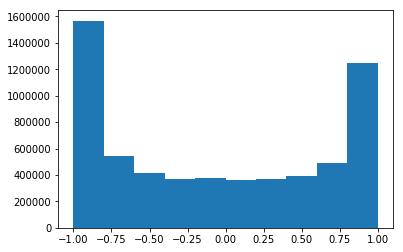

In [8]:
plt.hist(crisp_states[:,:,:].flatten())

(array([ 1561171.,   549366.,   414598.,   371468.,   378842.,   363650.,
          369830.,   397153.,   497606.,  1240316.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

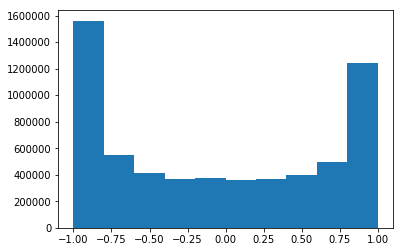

In [36]:
plt.hist(crisp_states[:,:,:].flatten())

(array([  87700.,   68359.,   84460.,  107562.,  151311.,  150508.,
         111242.,   89956.,   80084.,   92818.]),
 array([ -9.99999106e-01,  -7.99999535e-01,  -5.99999964e-01,
         -4.00000393e-01,  -2.00000823e-01,  -1.25169754e-06,
          1.99998319e-01,   3.99997890e-01,   5.99997461e-01,
          7.99997032e-01,   9.99996603e-01]),
 <a list of 10 Patch objects>)

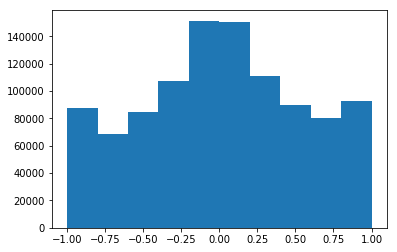

In [35]:
plt.hist(belief_states[60:80,:,:].flatten())

In [10]:
plt.hist(belief_states[60:80,:,:].flatten())

NameError: name 'belief_states' is not defined